In [1]:

#Basic libraries
import pandas as pd
import numpy as np


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
raw_reviews = pd.read_csv('Data Analyst - Test Data - US.csv')
## print shape of dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(6448, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    6393 non-null   object
 1   date      6448 non-null   object
 2   Location  1711 non-null   object
dtypes: object(3)
memory usage: 151.2+ KB
None


In [3]:
raw_reviews.head()

,Review,date,Location
0,I was very impressed with the resort.\n Great ...,2019/08/20,Sebastian
1,The rooms were nice the outside needs work als...,2019/08/20,Los Angeles
2,Great location! I have stayed at this hotel on...,2019/08/20,Georgia
3,The hotel was adequate for my stay. The strips...,2019/08/20,NaN
4,"Great location, room was large and spacious. P...",2019/08/19,Palm Harbor


In [4]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

Review        55
date           0
Location    4737
dtype: int64

In [6]:
mode_location = process_reviews['Location'].mode()[0]
process_reviews['Location'].fillna(mode_location, inplace=True)

In [7]:
process_reviews.isnull().sum()

Review      55
date         0
Location     0
dtype: int64

In [8]:
process_reviews.dropna(inplace=True)

In [9]:
process_reviews.isnull().sum()

Review      0
date        0
Location    0
dtype: int64

In [13]:
# Splitting the date
new1 = process_reviews["date"].str.split("/", n = 2, expand = True)



In [14]:
new1

,0,1,2
0,2019,08,20
1,2019,08,20
2,2019,08,20
3,2019,08,20
4,2019,08,19
...,...,...,...
6443,2019,07,12
6444,2019,07,12
6445,2019,07,10
6446,2019,07,10


In [15]:
# adding year to the main dataset
process_reviews["year"]= new1[0]

# adding month to the main dataset
process_reviews["month"]= new1[1]

# adding day to the main dataset
process_reviews["day"]= new1[2]

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

,Review,Location,year,month,day
0,I was very impressed with the resort.\n Great ...,Sebastian,2019,08,20
1,The rooms were nice the outside needs work als...,Los Angeles,2019,08,20
2,Great location! I have stayed at this hotel on...,Georgia,2019,08,20
3,The hotel was adequate for my stay. The strips...,United States of America,2019,08,20
4,"Great location, room was large and spacious. P...",Palm Harbor,2019,08,19


In [16]:
#Creating a copy
clean_reviews=process_reviews.copy()

In [17]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [19]:
process_reviews['Review']=process_reviews['Review'].apply(lambda x:review_cleaning(x))
process_reviews.head()

,Review,Location,year,month,day
0,i was very impressed with the resort great sta...,Sebastian,2019,08,20
1,the rooms were nice the outside needs work als...,Los Angeles,2019,08,20
2,great location i have stayed at this hotel on ...,Georgia,2019,08,20
3,the hotel was adequate for my stay the strips ...,United States of America,2019,08,20
4,great location room was large and spacious par...,Palm Harbor,2019,08,19


In [20]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=9334349d412d805c93d78931297609aca2531d33616a7d38f91bf54af6f3f334
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [21]:
from langdetect import detect

# Function to detect language
def detect_language(text):
    try:
        lang = detect(text)
        return lang == 'en'  # Keep only English reviews
    except:
        return False

# Apply language detection and filter DataFrame
process_reviews = process_reviews[process_reviews['Review'].apply(detect_language)]

# Display the DataFrame after filtering non-English reviews
print("\nDataFrame with only English reviews:")
print(process_reviews)


DataFrame with only English reviews:
                                                 Review  \
0     i was very impressed with the resort great sta...   
1     the rooms were nice the outside needs work als...   
2     great location i have stayed at this hotel on ...   
3     the hotel was adequate for my stay the strips ...   
4     great location room was large and spacious par...   
...                                                 ...   
6443  ·the staff were all so friendly frank the chef...   
6444          ·the internet barely worked or didnt work   
6445  ·the location was great     ·the bed was the m...   
6446  ·we were early for check in and the staff was ...   
6447  ·staff free coffee location and activities    ...   

                      Location  year month day  
0                    Sebastian  2019    08  20  
1                  Los Angeles  2019    08  20  
2                      Georgia  2019    08  20  
3     United States of America  2019    08  20  
4       

In [22]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't",
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [24]:
process_reviews['Review'] = process_reviews['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

,Review,Location,year,month,day
0,impressed resort great staff main resort pool ...,Sebastian,2019,08,20
1,rooms nice outside needs work also no free bre...,Los Angeles,2019,08,20
2,great location stayed hotel last three trips n...,Georgia,2019,08,20
3,hotel adequate stay strips bathtub useless fel...,United States of America,2019,08,20
4,great location room large spacious parking eas...,Palm Harbor,2019,08,19


In [31]:
#Checking for null values
process_reviews.isnull().sum()

Review        0
Location      0
year          0
month       649
day         649
dtype: int64

In [32]:
#delecting null values
process_reviews.dropna(inplace=True)
process_reviews.isnull().sum()

Review      0
Location    0
year        0
month       0
day         0
dtype: int64

In [33]:
# Check unique values in the 'year' column
unique_years = process_reviews['year'].unique()
unique_years

array(['2019', '2018'], dtype=object)

## Day of month vs Reviews count
**Let's check if there are any relationship between reviews and day of month**

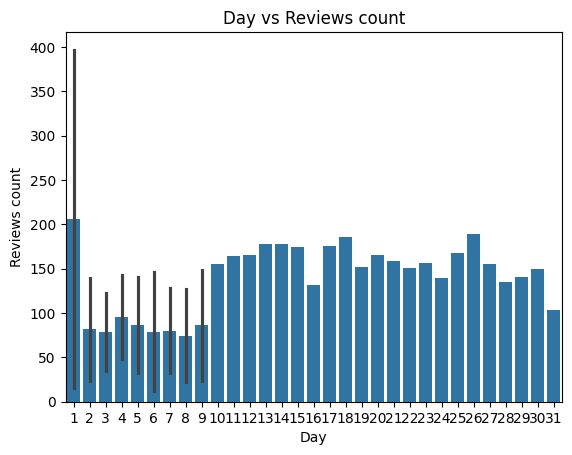

In [34]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['Review'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
sns.barplot(x="day", y="Review", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

On the first day of month there are highest number of review count and from day 2 to day 9 has lowest number of review count

## Month vs Reviews count
**Let's check if there are any relationship between reviews and Month**

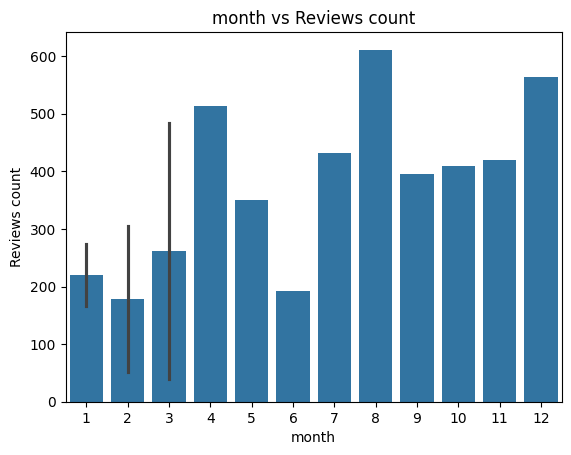

In [35]:
#Creating a dataframe
month=pd.DataFrame(process_reviews.groupby('month')['Review'].count()).reset_index()
month['month']=month['month'].astype('int64')
month.sort_values(by=['month'])

#Plotting the graph
sns.barplot(x="month", y="Review", data=month)
plt.title('month vs Reviews count')
plt.xlabel('month')
plt.ylabel('Reviews count')
plt.show()

January, February and June has less number of review count where as August April and december has Highest number of review count

## Year vs Reviews count
**Let's check if there are any relationship between reviews and Year**

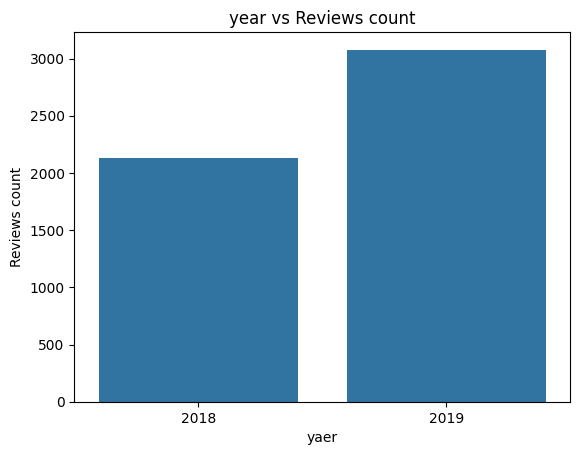

In [36]:
#Creating a dataframe
year=pd.DataFrame(process_reviews.groupby('year')['Review'].count()).reset_index()
year['year']=year['year'].astype('int64')
year.sort_values(by=['year'])

#Plotting the graph
sns.barplot(x="year", y="Review", data=year)
plt.title('year vs Reviews count')
plt.xlabel('yaer')
plt.ylabel('Reviews count')
plt.show()

There are more reviews in 2019 i.e. around 3000 rather than in 2018 i.e. 2200

## Location vs Reviews count
**Let's check if there are any relationship between reviews and Loaction**

In [57]:
# Check unique values in the 'Location' column
unique_Loc = process_reviews['Location'].unique()
#Creating a dataframe
Loc=pd.DataFrame(process_reviews.groupby('Location')['Review'].count()).reset_index()
Loc

,Location,Review
0,2186,1
1,Abbotsford BC,1
2,Alabama,1
3,Albany NY,1
4,"Albany, NY",1
...,...,...
971,us,1
972,wGreeashin\n \n Greendale,1
973,warwick ny,1
974,"wyndham garden silicon valley ,san jose ca.",1


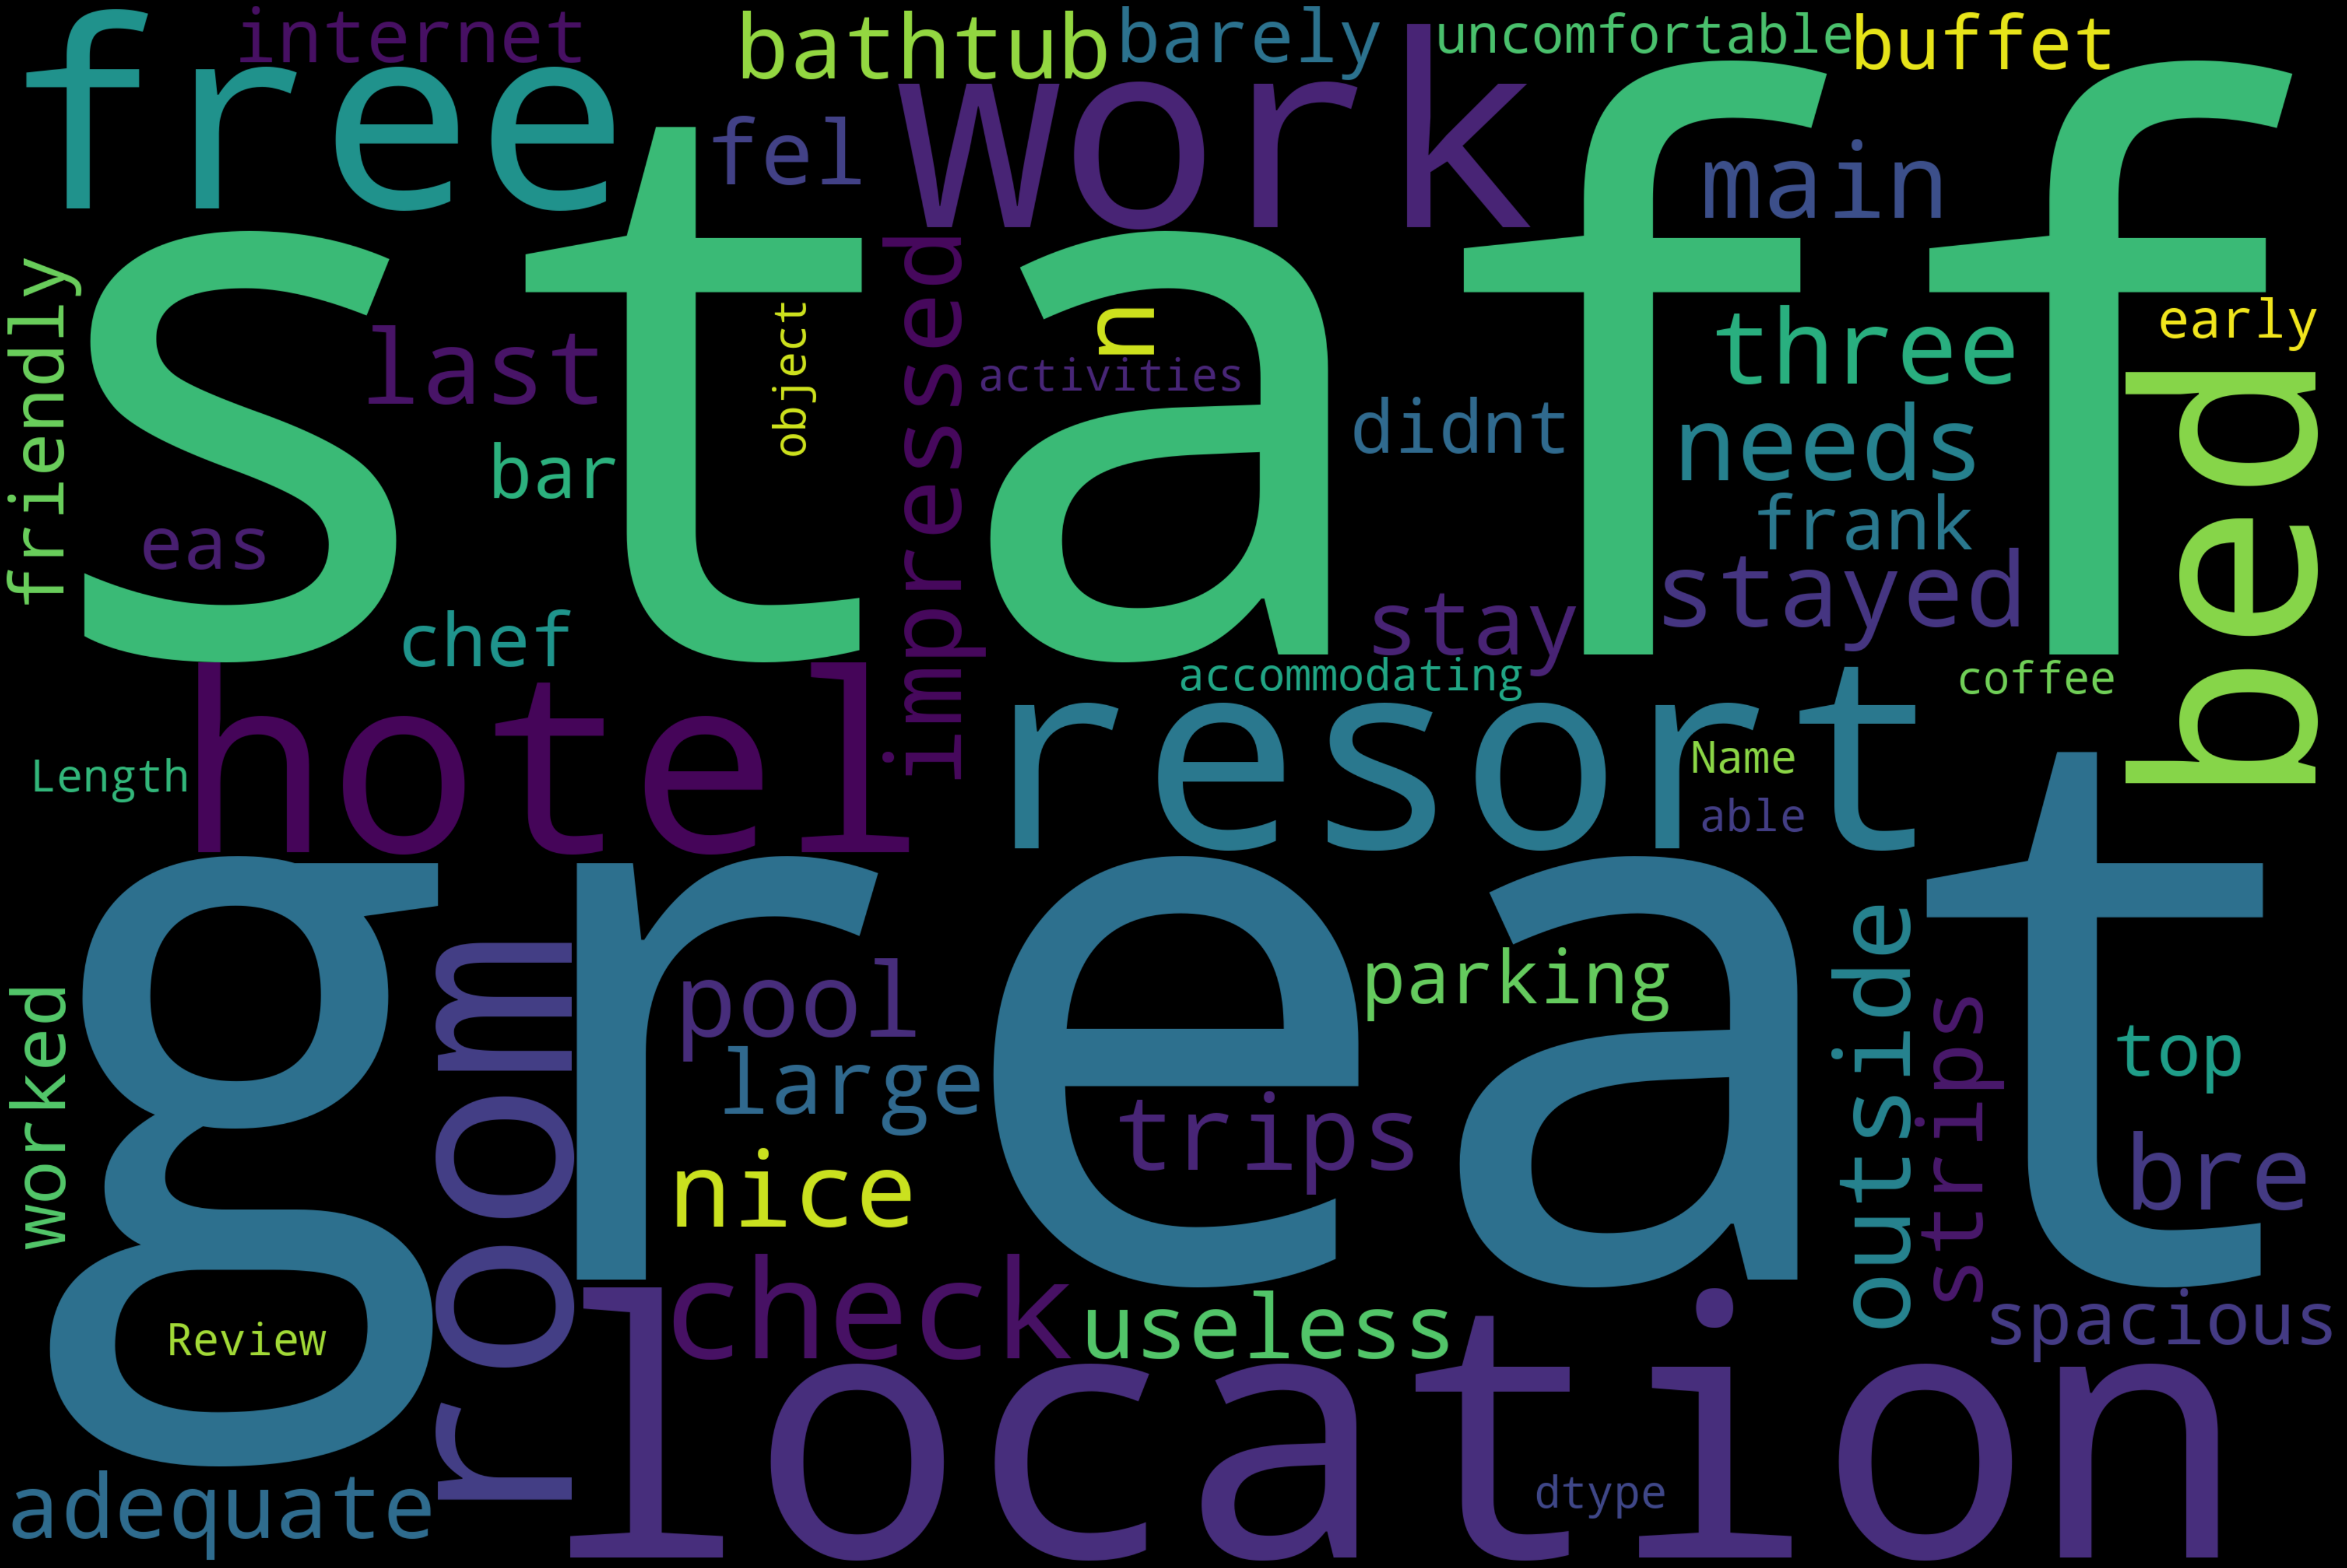

In [37]:
text = process_reviews["Review"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The Most occuring words in the dataset are staff, greate, location, room, resort, hotel, free, work, bathtub, bed, adequte, useless, barly, uncomfortable, etc

## Stemming the reviews
**Stemming is a method of deriving root word from the inflected word. Here we extract the reviews and convert the words in reviews to its root word. for example,**
* **Going->go**
* **Finally->fina**

**If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning. Simce it takes time. I'm using stemming**

In [38]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['Review']].reset_index(drop=True)
review_features.head()

,Review
0,impressed resort great staff main resort pool ...
1,rooms nice outside needs work also no free bre...
2,great location stayed hotel last three trips n...
3,hotel adequate stay strips bathtub useless fel...
4,great location room large spacious parking eas...


In [39]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['Review'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)

In [40]:
corpus[3]

'hotel adequ stay strip bathtub useless fell take shower ask front desk staff sever time get bath mat but never manag unrespons request poor someon gone dollar store gotten bath mat breakfast good but would nice yogurt andor cottag chees buffet read read less'

## TFIDF(Term Frequency — Inverse Document Frequency)
**TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.**

**Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.**

In [41]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['Review'])

In [42]:
X.shape

(5209, 5000)

**As we have considered 5000 words, we can confirm that we have 5000 columns from the shape.**

In [45]:
!pip install transformers
!pip install torch
!pip install scikit-learn

In [58]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import numpy as np

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Tokenize and obtain BERT embeddings for each sentence
tokenized_texts = [tokenizer(text, return_tensors='pt') for text in review_features['Review']]
embeddings = [model(**tokens).last_hidden_state.mean(dim=1).detach().numpy() for tokens in tokenized_texts]

# Concatenate embeddings to form feature vectors
features = np.concatenate(embeddings, axis=0)

# Use KMeans for clustering (you can adjust the number of clusters as needed)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)




In [49]:
# Create a DataFrame with 'review' and 'cluster' columns
df = pd.DataFrame({'review': review_features['Review'], 'cluster': clusters})

# Save the DataFrame to a CSV file
df.to_csv('review_clusters.csv', index=False)

# Display the DataFrame
print("\nDataFrame with 'review' and 'cluster' columns:")
print(df)


DataFrame with 'review' and 'cluster' columns:
                                                 review  cluster
0     impressed resort great staff main resort pool ...        0
1     rooms nice outside needs work also no free bre...        0
2     great location stayed hotel last three trips n...        0
3     hotel adequate stay strips bathtub useless fel...        1
4     great location room large spacious parking eas...        0
...                                                 ...      ...
5204  ·the staff friendly frank chef buffet bar top ...        1
5205             ·the internet barely worked didnt work        0
5206  ·the location great ·the bed uncomfortable bed...        1
5207  ·we early check staff accommodating able check...        1
5208  ·staff free coffee location activities ·the be...        1

[5209 rows x 2 columns]


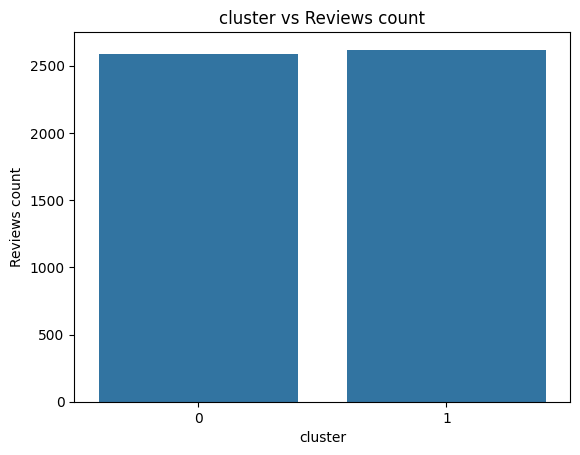

In [59]:
#Creating a dataframe
cluster=pd.DataFrame(df.groupby('cluster')['review'].count()).reset_index()
cluster['cluster']=cluster['cluster'].astype('int64')
cluster.sort_values(by=['cluster'])

#Plotting the graph
sns.barplot(x="cluster", y="review", data=cluster)
plt.title('cluster vs Reviews count')
plt.xlabel('cluster')
plt.ylabel('Reviews count')
plt.show()